In [1]:
import logging
import os.path

import numpy as np
from poap.controller import BasicWorkerThread, ThreadController

from pySOT.auxiliary_problems import candidate_uniform
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.experimental_design import LatinHypercube
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail
from pySOT.strategy import SRBFStrategy
from pySOT.optimization_problems import SixHumpCamel
from pySOT.utils import unit_rescale
from pySOT.strategy import DYCORSStrategy,SOPStrategy
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import scipy.spatial as scpspatial
import scipy
from scipy.integrate import quad
import random

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [2]:
class ThreeHumpCamel(SixHumpCamel):
    """Three-hump camel function

    Details: https://www.sfu.ca/~ssurjano/camel3.html

    Global optimum: :math:`f(0,0)=0`

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """
    
    def __init__(self):
        self.min = 0
        self.minimum = np.array([0, 0])
        self.dim = 2
        self.lb = -5.0 * np.ones(2)
        self.ub = 5.0 * np.ones(2)
        self.int_var = np.array([])
        self.cont_var = np.arange(0, 2)
        self.info = "2-dimensional Three-hump function \nGlobal optimum: " + "f(0, 0) = 0"

    def eval(self, x):
        """Evaluate the Three Hump Camel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        return 2*x[0]**2 - 1.05*x[0]**4 + (x[0]**6)/6 + x[0]*x[1] + x[1]**2
    

In [3]:
class Lm_ThreeHumpCamel(ThreeHumpCamel):
    """Three-hump camel function

    Details: https://www.sfu.ca/~ssurjano/camel6.html

    Global optimum: :math:`f(0,0)=0`

    :ivar dim: Number of dimensions
    :ivar lb: Lower variable bounds
    :ivar ub: Upper variable bounds
    :ivar int_var: Integer variables
    :ivar cont_var: Continuous variables
    :ivar min: Global minimum value
    :ivar minimum: Global minimizer
    :ivar info: String with problem info
    """
    
    def __init__(self,ep = 1):
        self.ep = ep
        ThreeHumpCamel.__init__(self)
        #self.c = self.eval(np.random.random(size = 2))
        self.c = 0.75
        self.H_ys = []
        self.beta = 1/ep
        

            # linear f
    def eval1(self, x):
        """Evaluate the modified ThreeHumpCamel function  at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.log((H_y - self.c + self.ep)/self.ep)
        else:
            return (
                scipy.integrate.quad(lambda u: 1/(u - self.c + self.ep), a = self.min, b = H_y)[0]
            )
    
    # quadratic f
    def eval2(self, x):
        """Evaluate the modified ThreeHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return self.beta*(self.c - self.min) + np.sqrt(self.beta)*np.arctan(np.sqrt(self.beta)*(H_y - self.c))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**2 + self.ep), a = self.min, b = H_y)[0]
            )
    
    # square root f
    def eval3(self, x):
        """Evaluate the modified ThreeHumpCamel function at x

        :param x: Data point
        :type x: numpy.array
        :return: Value at x
        :rtype: float
        """
        self.__check_input__(x)
        H_y = self.eval(x)
        #if H_y <= self.c:
         #   self.c = H_y
        self.H_ys.append(H_y)
        d = float(self.dim)
        if H_y <= self.min:
            return 0
        elif self.c >= H_y > self.min:
            return self.beta*(H_y - self.min)
        elif H_y > self.c >= self.min:
            return (self.beta*(self.c - self.min) + 2*np.sqrt(H_y - self.c)
                    - 2*self.ep*np.log((np.sqrt(H_y - self.c) + self.ep)/self.ep))
        else:
            return (
                scipy.integrate.quad(lambda u: 1/((u - self.c)**(1/2) + self.ep), a = self.min, b = H_y)[0]
            )

In [111]:
def ex_helper(times):
    max_evals = 100
    l2 = np.zeros((max_evals,times))
    for i in range(times):
        np.random.seed(i)
        random.seed(i)
        lm_threeHumpCamel = Lm_ThreeHumpCamel()
        rbf = RBFInterpolant(dim=lm_threeHumpCamel.dim, lb=lm_threeHumpCamel.lb, ub=lm_threeHumpCamel.ub, kernel=CubicKernel(), tail=LinearTail(lm_threeHumpCamel.dim))
        slhd = SymmetricLatinHypercube(dim=lm_threeHumpCamel.dim, num_pts=2 * (lm_threeHumpCamel.dim + 1))
        controller1 = SerialController(objective=lm_threeHumpCamel.eval)
        controller1.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_threeHumpCamel, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )


        # Run the optimization strategy
        result1 = controller1.run()
        l2[:,i] = np.array(
                [o.value for o in controller1.fevals if o.value is not None])
    return l2

In [112]:
l2 = ex_helper(30)

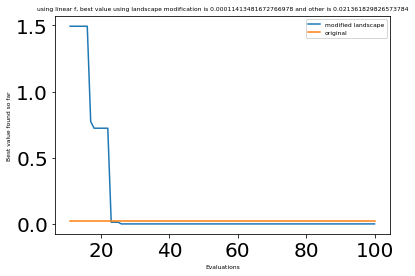

(0.00011413481672766978, 0.021361829826573784)

In [213]:
%matplotlib inline
path = '/Users/venkatkrishnakarumanchi/Desktop/surrogate optimization research/pySOT-master/three_hump_camel_results/square root landscape/0.75_c'
# when I do it serially and also not asynchronously I am able to make it deterministic

    
def example_simple(state,path,i,l2):
    np.random.seed(state)
    random.seed(state)
    if not os.path.exists("./logfiles"):
        os.makedirs("logfiles")
    if os.path.exists("./logfiles/example_simple.log"):
        os.remove("./logfiles/example_simple.log")
    logging.basicConfig(filename="./logfiles/example_simple.log", level=logging.INFO)

    max_evals = 100
    
    lm_threeHumpCamel = Lm_ThreeHumpCamel()
    rbf = RBFInterpolant(dim=lm_threeHumpCamel.dim, lb=lm_threeHumpCamel.lb, ub=lm_threeHumpCamel.ub, kernel=CubicKernel(), tail=LinearTail(lm_threeHumpCamel.dim))
    slhd = SymmetricLatinHypercube(dim=lm_threeHumpCamel.dim, num_pts=2 * (lm_threeHumpCamel.dim + 1))

    # Create a strategy and a controller
    # can change landscape by changing eval1 to eval2 or eval3 based on preferance
    controller = SerialController(objective=lm_threeHumpCamel.eval3)
    controller.strategy = SRBFStrategy(
        max_evals=max_evals, opt_prob=lm_threeHumpCamel, exp_design=slhd, surrogate=rbf, asynchronous=False,batch_size = 1
        )

    # Run the optimization strategy
    result = controller.run()
    l1 = lm_threeHumpCamel.H_ys

    fvals1 = np.minimum.accumulate(l1)
    fvals2 = np.minimum.accumulate(l2[:,i])
    for results in [fvals1[10:],fvals2[10:]]:
        plt.errorbar(np.arange(start = 10, stop = 100)+1, y=results)


    plt.ylabel("Best value found so far", fontsize=6)
    plt.xlabel("Evaluations", fontsize=6)
    plt.legend(("modified landscape", "original"), fontsize=6)
    plt.title('using linear f, best value using landscape modification is {0} and other is {1}'.
              format(lm_threeHumpCamel.eval(result.params[0]),min(l2[:,i])),
              fontsize = 6)
    #plt.figure(facecolor=(1, 1, 1))
    plt.savefig(path + '/graph_iter_{0}.jpg'.format(i), dpi = 200)
    plt.show()

    
    return lm_threeHumpCamel.eval(result.params[0]),min(l2[:,i])
    


example_simple(0,path,0,l2)

In [214]:
def rmse(x,x1):
    return np.sqrt(np.mean((x - x1)**2))

def checker(times,path,l2):
    lm = 0
    lm_list = []
    no_lm = 0
    no_lm_list = []
    for i in range(times):
        res = example_simple(i,path,i,l2)
        lm_list.append(res[0])
        no_lm_list.append(res[1])
        if res[0] < res[1]:
            lm += 1
        else:
            no_lm += 1
    print('landscape modified was better {0} times and was worse {1} times'.format(lm,no_lm))
    print('mean of landscape modified is {}'.format(np.mean(lm_list)))
    print('mean of non landscape modified is {}'.format(np.mean(no_lm_list)))
    print('median of landscape modified is {}'.format(np.median(lm_list)))
    print('median of non landscape modified is {}'.format(np.median(no_lm_list)))
    print('best result of landscape modified is {}'.format(np.min(lm_list)))
    print('best of non landscape modified is {}'.format(np.min(no_lm_list)))
    print('worst result of landscape modified is {}'.format(np.max(lm_list)))
    print('worst of non landscape modified is {}'.format(np.max(no_lm_list)))
    return lm_list,no_lm_list
    

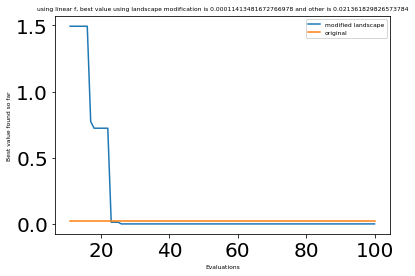

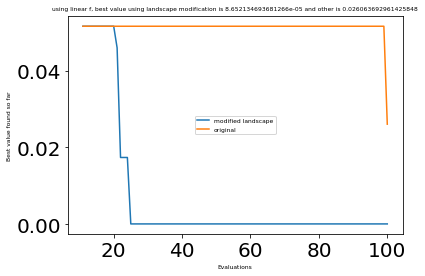

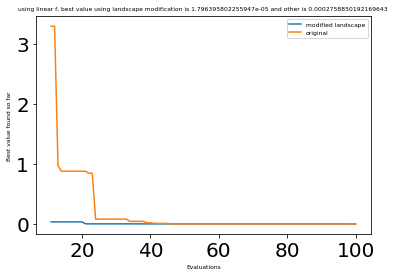

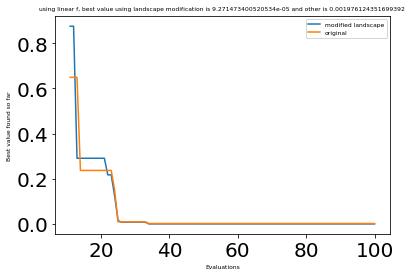

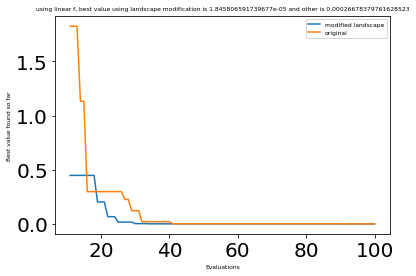

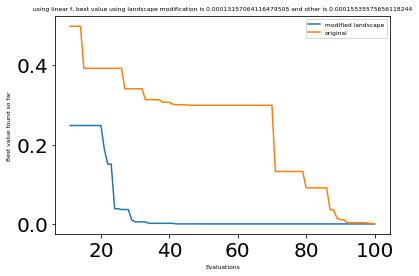

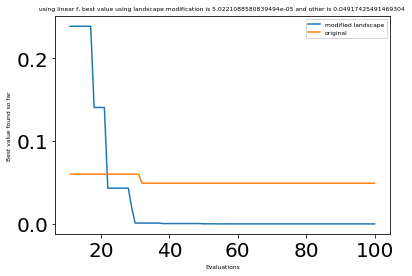

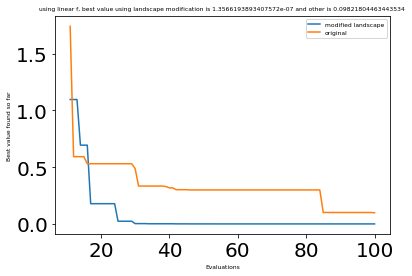

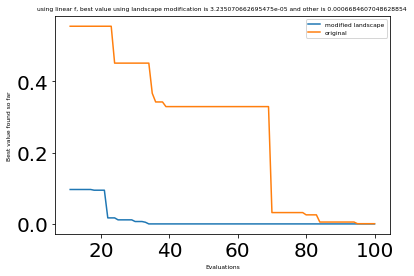

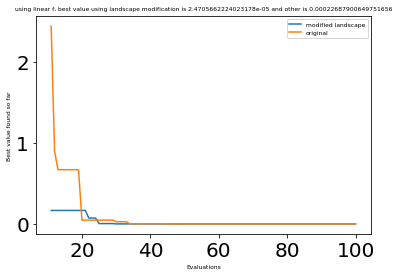

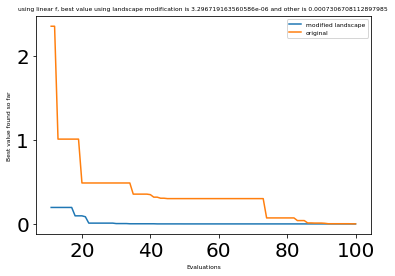

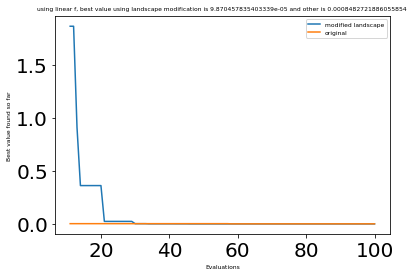

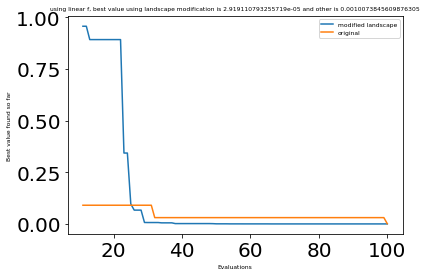

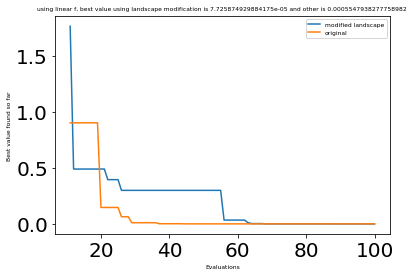

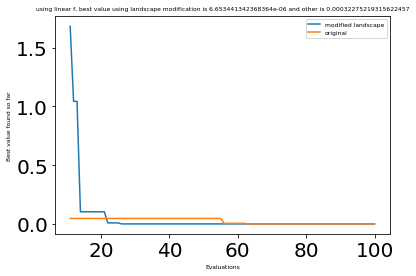

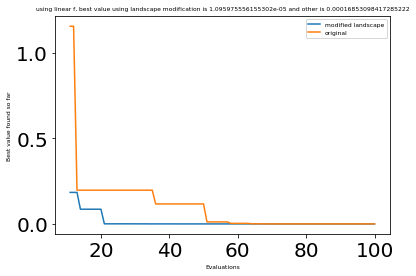

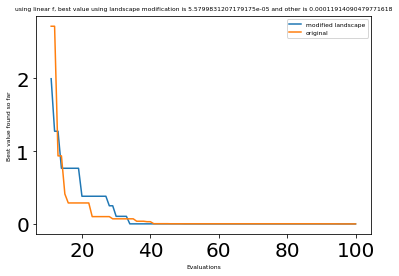

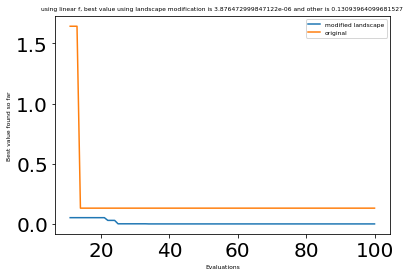

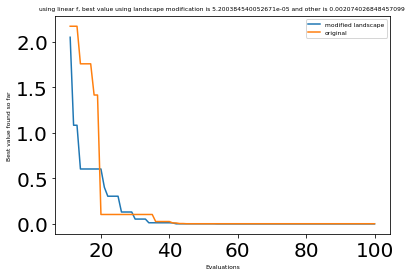

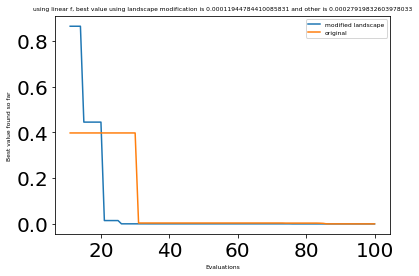

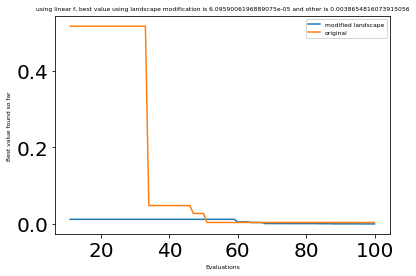

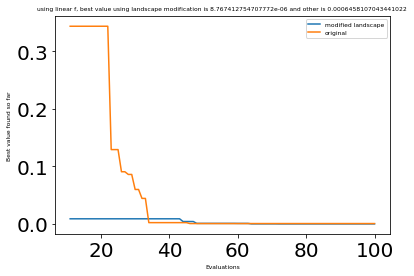

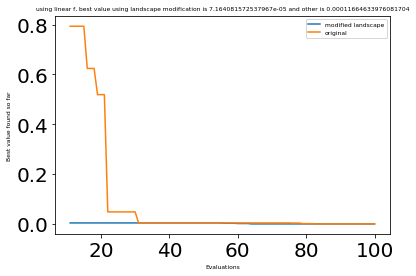

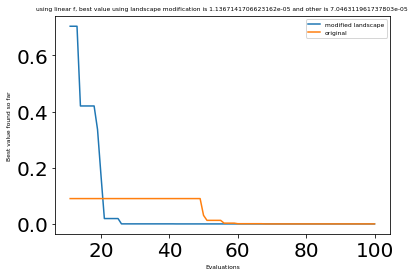

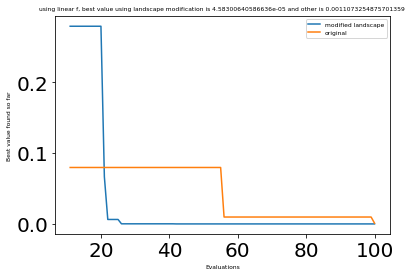

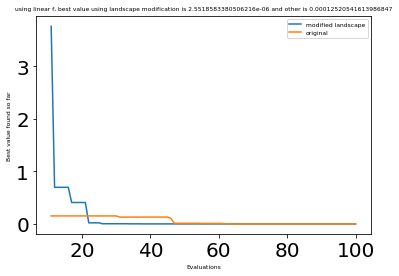

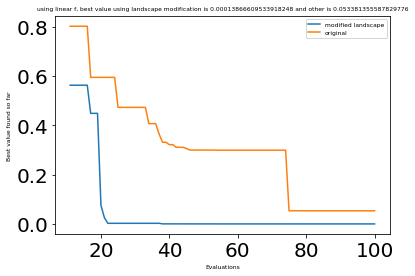

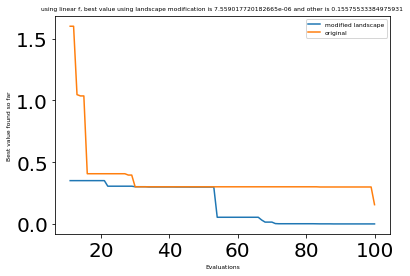

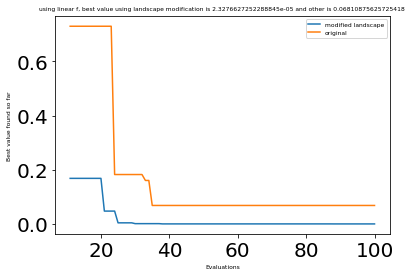

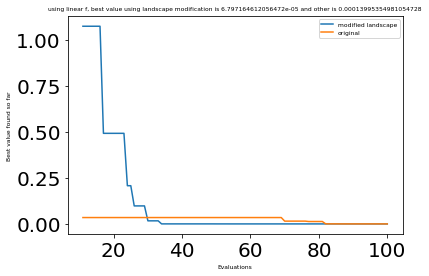

landscape modified was better 30 times and was worse 0 times
mean of landscape modified is 4.881862375730162e-05
mean of non landscape modified is 0.020624935151171926
median of landscape modified is 3.9090385342809175e-05
median of non landscape modified is 0.0006995657580763419
best result of landscape modified is 1.3566193893407572e-07
best of non landscape modified is 7.046311961737803e-05
worst result of landscape modified is 0.00013866609533918248
worst of non landscape modified is 0.15575533384975931


([0.00011413481672766978,
  8.652134693681266e-05,
  1.796395802255947e-05,
  9.271473400520534e-05,
  1.845806591739677e-05,
  0.00013157064116479505,
  5.0221088580839494e-05,
  1.3566193893407572e-07,
  3.235070662695475e-05,
  2.4705662224023178e-05,
  3.296719163560586e-06,
  9.870457835403339e-05,
  2.919110793255719e-05,
  7.725874929884175e-05,
  6.653441342368364e-06,
  1.095975556155302e-05,
  5.5799831207179175e-05,
  3.876472999847122e-06,
  5.200384540052671e-05,
  0.00011944784410085831,
  6.0959006196889075e-05,
  8.767412754707772e-06,
  7.164081572537967e-05,
  1.1367141706623162e-05,
  4.58300640586636e-05,
  2.5518583380506216e-06,
  0.00013866609533918248,
  7.559017720182665e-06,
  2.3276627252288845e-05,
  6.797164612056472e-05],
 [0.021361829826573784,
  0.026063692961425848,
  0.0002758850192169643,
  0.001976124351699392,
  0.00026678379761628523,
  0.00015535575656118244,
  0.04917425491469304,
  0.09821804463443534,
  0.0006684607048628854,
  0.00022687900649

In [215]:
checker(30,path,l2)